This notebook displays the ability of our method to reconstruct a dense local light field with 5x5 views from its monochromatic 2D projection after filtering by a color-coded mask placed between the sensor and the aperture, and a bayer color filter array.

In [1]:
import sys
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

sys.path.append(os.path.abspath(".."))

# so that TF does not use up all the GPU memory
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from dataset import DatasetBuilder, PathsHelper
from custom.functions import psnr
from custom.regularizers import EntropyRegularizer

2025-03-30 16:36:02.963891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-30 16:36:03.303538: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 16:36:03.483714: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 16:36:04.888106: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
model_path = "models/random/best.tf"
model = tf.keras.models.load_model(model_path, compile=False, custom_objects={'EntropyRegularizer': EntropyRegularizer, 'psnr': psnr})
model.summary()

2025-03-30 16:36:07.038994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-30 16:36:07.044484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-30 16:36:07.044567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-30 16:36:07.044584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may h

Model: "functional_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, None  0         
                             , None, 3)]                         
                                                                 
 pixelwise_acquisition_recon  (None, None, None, None,  5618077  
 struction (PixelwiseAcquisi   None, 3)                          
 tionReconstruction)                                             
                                                                 
Total params: 5,618,077
Trainable params: 5,618,077
Non-trainable params: 0
_________________________________________________________________


In [3]:
def show_lf(lf, title=None):
    """
    Display a view of the light field and and epipolar slice"
    """
    cv = lf[0, :, :, 2, 2]
    plt.imshow(cv)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()

    epi = lf[0, 32, :, 2, :]
    epi = tf.transpose(epi, perm=[1, 0, 2])
    plt.imshow(epi)
    plt.axis('off')
    plt.show()

In [4]:
file_descriptions = [
    {'root_dir': 'data/test',
     'format': 'lf_{v+1+(8-angular_resolution)//2}_{u+1+(8-angular_resolution)//2}.png'}]
options = {'batch_size': 1, 'patch_height': 375, 'patch_width': 541, 'shuffle': False} # change the patch size if needed
angular_resolution = 5

paths_tensor = PathsHelper.get_paths_tensor_from_description(file_descriptions, angular_resolution)
dataset = DatasetBuilder(paths_tensor, **options).make()

for i, gt in enumerate(dataset):
    pred = model(gt)
    break

2025-03-30 16:36:14.782923: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x556b8009d710
2025-03-30 16:36:19.146229: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


### Visual comparison 

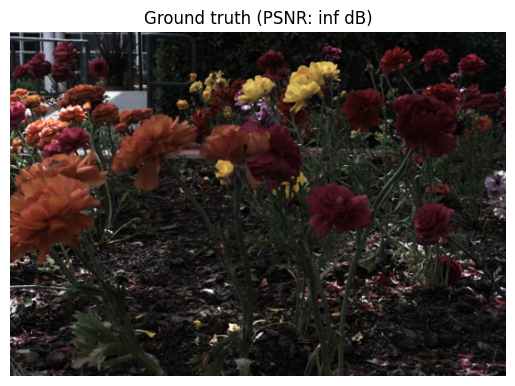

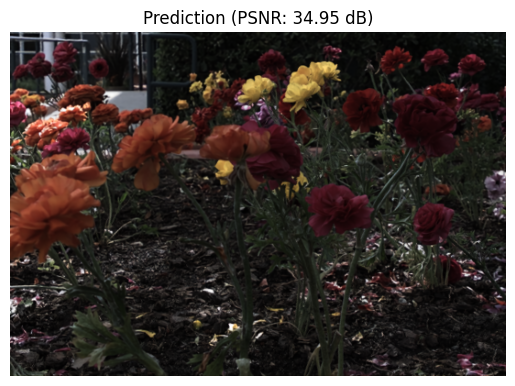

In [5]:
for lf, name in zip([gt, pred], ["Ground truth", "Prediction"]):
    score = psnr(lf, gt)
    show_lf(lf, name + f" (PSNR: {score:.2f} dB)")

### Interactive visualization

In [6]:
# Create a list of 3 example light fields.
num_light_fields = 2
tf2cv2 = lambda x: tf.stack([x[..., 2], x[..., 1], x[..., 0]], axis=-1).numpy()
light_fields = [tf2cv2(lf[0]) for lf in [gt, pred]]
current_idx = 0

window_name = 'Light Field Viewer'
cv2.namedWindow(window_name)

def update_view(x, y):
    lf = light_fields[current_idx]
    height, width, v_views, h_views, _ = lf.shape
    cell_w = width / h_views
    cell_h = height / v_views
    col = min(int(x // cell_w), h_views - 1)
    row = min(int(y // cell_h), v_views - 1)
    view = lf[:, :, row, col, :]
    cv2.imshow(window_name, view)

def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:
        update_view(x, y)

cv2.setMouseCallback(window_name, mouse_callback)

def on_trackbar(val):
    global current_idx
    current_idx = val
    lf = light_fields[current_idx]
    cv2.imshow(window_name, lf[:, :, 0, 0, :])

cv2.createTrackbar('Light Field', window_name, 0, num_light_fields - 1, on_trackbar)

# Show the initial view.
cv2.imshow(window_name, light_fields[current_idx][:, :, 0, 0, :])

# Loop and check if the window is still open.
while cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE) >= 1:
    cv2.waitKey(100)

cv2.destroyAllWindows()